# FIN40040 - Numerical Methods


## Group Project Report

### Team

*Jianan, LI (19211179)*

*Zhaocheng, LI 

*Lu, YANG 

*Jing, ZHANG 

## INTRODUCTION

The project starts with a stock price that follows a risk-neutral Geometric Brownian Motion (GBM) with

`dS = rSdt + σSdz`

where `dz` is the increment in the Wiener process, `r=5%`, and `σ=30%`. The initial stock price is assumed as `S0=100`.

The main focus of this project is various methods of pricing a American put option with given parameters and changing number of times to exercise it (2 times and 52 times). For this project, we are able to price the option with methods of
- Implicit Finite Difference (IFD)
- Regular Monte Carlo (MC)
- Conditional Monte Carlo (CMC)
- Longstaff-Schwartz (LS) American option pricing algorithm and
- L-S algorithm with Jump-diffusion model.

And it's important to be able to compare the performance of those methods.

## METHODOLOGY

## RESULTS

### 1. Import important libraries and functions available from professor. 

In [1]:
# Import required libraries
import scipy.stats as si
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as si
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# function from professor
'''
A straightforward code to generate sample paths of asset 
prices following geometric brownian motion.
'''
def asset_paths_vec(S0, r, sigma, T, Nsteps, Nsim, seed):
    np.random.seed(seed)
    dt = T/Nsteps
    nudt = (r - 0.5*sigma**2)*dt
    sidt = sigma*np.sqrt(dt)
    eps = np.random.normal(0,1,(Nsim, Nsteps))
    dlnS = nudt + sidt*eps
    lnS0 = np.log(S0)*np.ones((Nsim,1))
    lnS1 = np.hstack((lnS0,dlnS))
    lnS = np.cumsum(lnS1,axis=1)
    Spaths = np.exp(lnS)
    Spaths[:,0] = S0
    return Spaths

In [3]:
# function from professor
'''
Monte Carlo simulation of Merton's Jump Diffusion Model.

Output: 
simulated_path, a sample paths of asset prices following GBM.
'''
def jump_diffusion(S0, K, T, r, sigma, Lambda, a, b, Nsteps, Nsim, alpha, seed):
    np.random.seed(seed)
    tic = time.time()
    dt = T/Nsteps
    mean_Y = np.exp(a + 0.5*(b**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    M = S0 * np.exp(r*T + Lambda*T*(mean_Y-1))
    V = S0**2 * (np.exp((2*r + sigma**2)*T
                       + Lambda*T*(variance_Y + mean_Y**2 - 1)) - np.exp(2*r*T + 2*Lambda*T*(mean_Y - 1)))
    simulated_paths = np.zeros([Nsim, Nsteps+1])
    simulated_paths[:,0] = S0
    Z_1 = np.random.normal(size=[Nsim, Nsteps])
    Z_2 = np.random.normal(size=[Nsim, Nsteps])
    Poisson = np.random.poisson(Lambda*dt, [Nsim, Nsteps])
    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((r-sigma**2/2)*dt \
        + sigma*np.sqrt(dt) \
        * Z_1[:,i] + a*Poisson[:,i] \
        + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) \
        * Z_2[:,i])
    final_prices = simulated_paths[:,-1]
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    std_jump = np.std(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)
    ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    print("Merton's Jump Diffusion Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(M))
    print('Variance (V){:>17.4f}'.format(V))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Standard deviation {:>10.4f}'.format(std_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
    print('\nConfidence interval, Mean')
    print('-----------------------------')
    print('Alpha {:>23.2f}'.format(alpha))
    print('Lower bound {:>17.4f}'.format(ci_low))
    print('Upper bound {:>17.4f}'.format(ci_high))
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1) * Nsteps
    jump_diffusion = ax.plot(t, simulated_paths.transpose())
    plt.setp(jump_diffusion, linewidth=1)
   # ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
  #  diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
  #  $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\ .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
   # xlabel='Time (days)', ylabel='Stock price')
    plt.show()
    return simulated_paths

### 2. Implicit Finite Difference (IFD) method 

#### to price the twice-exercisable put option, the early exercise only happens once at *T=0.5*.

In [4]:
np.random.seed(0)

In [5]:
def IFD(stock_price, S0, K, r, T, sigma, Nsteps, Nsim):
    test_sp = np.delete(stock_price[:],0,axis=1) # delete the first column
    test = test_sp[np.lexsort(test_sp.T)] # sort test_sp 
    #print(test)
    
    S_expiry = test[:,-1] # subtract the expiry date in the column
    Smax = max(S_expiry)
    Smin = min(S_expiry) 
    dt = T/Nsteps
    V = np.zeros((Nsim,Nsteps)) # create a empty option value matrix
    Sv = S_expiry # we use random paths as our stock price
    iv = np.arange(Nsim)
    jv = np.arange(Nsteps)
    # boundary conditions
    V[:,-1] = np.maximum(K-Sv,0) 
    V[0,:] = K
    V[-1,:] = 0
    judge = V[1:-1,-1]
    # Set up a,b,c
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    # Set up tridiagonal coefficient matrix
    coef_mat =np.diag(a[2:Nsim-1],-1)+np.diag(b[1:Nsim-1])+np.diag(c[1:Nsim-2],1)
    LU, P = la.lu_factor(coef_mat)
    
    bc = np.zeros(Nsim-2) # creat a empty iteration array

    for j in reversed(np.arange(Nsteps-1)):
        bc[0] = -a[1]*V[0,j]
        bc[-1] = -c[-1]*V[-1,j]
        # Solve linear system A*V[1:M-1,j] = b with LU 
        V[1:-1,j] = np.maximum(la.lu_solve((LU, P),V[1:-1,j+1]+bc),judge)
        
    price = np.mean(V[1:,0])

    return [Sv,V[:,0],price]

In [6]:
# set parameters
S0 = 100
K = 105
r = 0.05
T = 1
sigma = 0.3
Nsteps = 2
Nsim = 10000
seed=1

In [7]:
# generate random paths of the stock price
stock_price = asset_paths_vec(S0, r, sigma, T, Nsteps, Nsim, seed)

In [8]:
price_IFD_2 = IFD(stock_price, S0, K, r, T, sigma, Nsteps, Nsim)
print(price_IFD_2)
print("The twice-exercisable put option price is ",price_IFD_2[2])

[array([ 31.81812925,  32.06725262,  33.4453868 , ..., 282.46546725,
       307.31585591, 313.89955584]), array([1.05000000e+02, 7.29327474e+01, 7.15546132e+01, ...,
       1.26788472e-04, 6.33906990e-05, 0.00000000e+00]), 12.527078285837364]
The twice-exercisable put option price is  12.527078285837364


So, the option using IFD is `12.5271` with 10,000 times of simulation.

### 3. Regular Monte Carlo (MC) method

#### to rice the twice-exercisable American put option.

In [9]:
np.random.seed(0)

In [10]:
def normfit(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), si.sem(a)
    h = se * si.t.ppf((1 + confidence) / 2., n - 1)
    var = np.var(data, ddof=1)
    sigma = np.sqrt(var)
    return m, sigma, np.hstack((m-h,m+h))

In [11]:
def mc(S0, K, r, T1, T2, sigma, Nsim1, Nsim2):
    Delt = T2-T1
    nuT1 = (r - 0.5*sigma**2)*T1
    nuT1T2 = (r - 0.5*sigma**2)*(T2-T1)
    
    siT1 = sigma * np.sqrt(T1)       # volatility
    siT1T2 = sigma * np.sqrt(T2-T1)
    
    epsT1 = np.random.normal(0,1,Nsim1)
    ST1 = S0*np.exp(nuT1 +siT1*epsT1)  # stock price
    DiscPayoff = np.zeros(Nsim1*Nsim2)
    
    for k in range(Nsim1):
        epsT2 = np.random.normal(0,1,Nsim2)
        ST2 = ST1[k]*np.exp(nuT1T2 +siT1T2*epsT2)
        exerciseT1 = np.mean(np.maximum(K-ST1,0))
        if exerciseT1 < K-ST1[k]:
            DiscPayoff[k*Nsim2:(k+1)*Nsim2] = np.exp(-r*T1)*np.maximum(K-ST1[k],0)
        else: 
            DiscPayoff[k*Nsim2:(k+1)*Nsim2] = np.exp(-r*T2)*np.maximum(K-ST2,0)
        price, SigPrice, CI = normfit(DiscPayoff)
    
    return price, SigPrice, CI

In [12]:
[price_mc,SigPrice_mc,CI_mc] = mc(S0=100,K=105,r=0.05,T1=0.5,T2=1,sigma=0.3,Nsim1 = 1000,Nsim2 = 1000)
print('Brute Force MC')
print('Twice-exercisable put price:',price_mc) # The results varies 
print('Twice-exercisable put CI:',CI_mc)
print('95% prop. error:',(CI_mc[1]-CI_mc[0])/price_mc)

Brute Force MC
Twice-exercisable put price: 12.460558019585257
Twice-exercisable put CI: [12.43626747 12.48484856]
95% prop. error: 0.0038987892222349277


So the twice-exercisable option price using MC method is `12.4606`.

### 4. Conditional Monte Carlo (CMC)  method

#### to price the same twice-exercisable American put option

In [13]:
np.random.seed(0)

In [14]:
def bs_price(S, K, r, T, sigma, option = 'put'):
    d1 = (np.log(S / K) +(r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) +(r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) -K * np.exp(-r*T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K *np.exp(-r*T) * si.norm.cdf(-d2, 0.0, 1.0) -S * si.norm.cdf(-d1, 0.0, 1.0))
    return result

In [15]:
def bs_mc2(S, K, r, T, sigma, Nsim):
    nuT = (r - 0.5*sigma**2)*T
    siT = sigma * np.sqrt(T)
    eps = np.random.normal(0,1,(Nsim,1))
    ST = S0*np.exp(nuT +siT*eps)
    Payoff = np.maximum(0, K-ST)
    DiscPayoff = np.exp(-r*T)*Payoff
    price, SigmaPrice, CI = normfit(DiscPayoff)
    return price, SigmaPrice, CI

In [16]:
def cmc(S0, K, r, T1, T2, sigma, Nsim):
    nuT1 = (r - 0.5*sigma**2)*T1
    siT1 = sigma * np.sqrt(T1)
    eps = np.random.normal(0,1,Nsim)
    ST1 = S0*np.exp(nuT1 +siT1*eps)
    exerciseT1 = np.mean(np.maximum(K-ST1,0))
    DiscPayoff = np.zeros(Nsim)
    for k in range(Nsim):
        if exerciseT1 < K-ST1[k]:
            DiscPayoff[k] = np.exp(-r*T1)*np.maximum(K-ST1[k],0)
        else: 
            DiscPayoff[k] = np.exp(-r*T1)*bs_price(ST1[k], K, r, T2-T1, sigma, option = 'put')
        price, SigPrice, CI = normfit(DiscPayoff)
    return price, SigPrice, CI

In [17]:
[price_cmc,SigPrice_cmc,CI_cmc] = cmc(S0=100,K=105,r=0.05,T1=0.5,T2=1,sigma=0.3,Nsim = 100000)
print('Conditional MC')
print('Twice-exercisable put price:',price_cmc)
print('Twice-exercisable put CI:',CI_cmc)
print('95% prop. error:',(CI_cmc[1]-CI_cmc[0])/price_cmc)

Conditional MC
Twice-exercisable put price: 12.028850708541084
Twice-exercisable put CI: [11.96458237 12.09311905]
95% prop. error: 0.010685698883572858


So the twice-exercisable option price with CMC method is `12.2080`, after 10000 times of simulation.

### 5. Longstaff-Schwartz (LS) American option pricing algorithm 

#### 5.1 First, to price the simple American put option on pages 116-120 of the paper with the same stock price paths in the paper.

In [18]:
np.random.seed(0)

In [19]:
def LS(stock_price, K, r, T, Nsteps, Nsim):    #Spaths: stock price matrix  
    stock_price_ = stock_price   # make a copy for stock price matrix  
    stock_price_ = np.delete(stock_price_[:],0,axis=1)  # delete the first column
    dt = T/Nsteps
    K_array = np.full((Nsim,Nsteps),K)  # create a K array to compare later
    c_f = np.maximum(K_array-stock_price_,0)   # make a cash flow matrix (determine whether to exercise)
    c_f_ = c_f  #make a copy for cash flow matrix
    for j in range(2,Nsteps+1):
        aim_col = c_f_[:,-j]  #Extract target column in cash flow matrix 
        #print(aim_col)
        ## Regression
        m = c_f_[aim_col>0,:]   #Extract the value of the target column greater than 0 (used for regression)
        #print(m)
        aim_s_col = stock_price_[:,-j]   #Extract the corresponding target column in stock price matrix  
        n = stock_price_[aim_s_col<K,:]  #Extract the value of in the money options corresponding to the stock target column
        #print(n)
        Y = m[:,-j+1]*np.exp(-r*dt)  # discounting stock price to get Y for regression
        #print(Y)
        X = n[:,-j]   # define X for regression
        REG = np.polyfit(X, Y, 2)  # we use polyfit here, and set degree of the fitting polynomial is 2
        ef = np.poly1d(REG) # Construct the polynomial 
        print("Estimated conditional expectation function:",ef)  ## showing fitted polynomial
        Continuation = aim_s_col  # we create a Continuation matrix here
        for i in range(0,len(Continuation)):  # we now generate continuation column
            if Continuation[i]<K:
                Continuation[i]=ef(Continuation[i])
            else:
                Continuation[i]=0
        #print(Continuation)
        cf_new_col = aim_col  # we make a copy here
        
        aim_col_minus1 = c_f_[:,-j+1]   #Extract the column which is t=-j+1
        for k in range(0,len(Continuation)):  # we now compare the value of immediate exercise with the value from continuation
            if cf_new_col[k]>Continuation[k]:
                cf_new_col[k]=cf_new_col[k]
                aim_col_minus1[k]=0
            else:
                cf_new_col[k]=0
        #print(cf_new_col,"==============")
        
        #print(aim_col_minus1,"==============")
        c_f_[:,-j]=cf_new_col  # we replace c_f_ with cf_new_col and aim_col_minus1
        c_f_[:,-j+1]=aim_col_minus1
        
        test_j_c_f_ = c_f_[:,-j:]  # creat a new matrix which inclde column(-j)
        #print(test_j_c_f_,"===========++++++++++")

        test_max_judge=[]
        for i in range(0,len(test_j_c_f_)):
            test_col = test_j_c_f_[i,:]
            test_max_judge_ = max(test_j_c_f_[i,:])   #we subtract the maximum value in each row in [test_j_c_f_]
            test_max_judge.append(test_max_judge_)  # append the new value in the [test_max_judge]
        #print(test_max_judge[1])
        test_j_c_f__ = test_j_c_f_
        for i in range(0,len(test_j_c_f__)):   
            test_j_c_f__l = test_j_c_f__[i,:]
            test_j_c_f__l[test_j_c_f__l<test_max_judge[i]]=0 # we replace the value in [test_j_c_f_] who is not the maximum into 0 in each row 
            test_j_c_f__[i,:] = test_j_c_f__l   # we append the new row in our marix
        #print(test_j_c_f__,"=========+++++++++===============")
        c_f_[:,-j:] = test_j_c_f__   #  we replace the new values into the original cash-flow matrix
        
    c_f_table = pd.DataFrame(c_f_)  # we convert cash-flow table into dataframe
    c_f_table_copy = c_f_table.copy(deep=True) # we do a copy here
    vi=[]
    for j in range(0,Nsteps):  # we create a discounting factors matrix
        vj = (j+1)*dt
        vi.append(vj)
    vi = np.array(vi) # convert into an array

    for kk in c_f_table_copy:   # we discount each column back to time=0
        c_f_table_copy[kk] = c_f_table_copy[kk]*np.exp(-r*vi[kk])
    c_f_table_copy['put option_value'] = c_f_table_copy.apply(lambda x:x.sum(),axis = 1) #sum of each value in every row
    option_value_final = c_f_table_copy['put option_value'].mean() # we compute the mean for each row in the last column
    result = option_value_final
    print(c_f_)
    print('Put Option Value is:')
    return result

the sample paths of stock price of the given problem from the paper is as follows

-|-|Stock Price Paths|-|-
-|-|-|-|-
Path|t = 0|t = 1|t = 2|t = 3
1|1.00|1.09|1.08|1.34
2|1.00|1.16|1.26|1.54
3|1.00|1.22|1.07|1.03
4|1.00|0.93|0.97|0.92
5|1.00|1.11|1.56|1.52
6|1.00|0.76|0.77|0.90
7|1.00|0.92|0.84|1.01
8|1.00|0.88|1.22|1.34

In [20]:
data_paper = np.array([[1.,1.09,1.08,1.34],
                      [1.,1.16,1.26,1.54],
                      [1.,1.22,1.07,1.03],
                      [1.,0.93,0.97,0.92],
                      [1.,1.11,1.56,1.52],
                      [1.,0.76,0.77,0.90],
                      [1.,0.92,0.84,1.01],
                      [1.,0.88,1.22,1.34]])

array([[1.  , 1.09, 1.08, 1.34],
       [1.  , 1.16, 1.26, 1.54],
       [1.  , 1.22, 1.07, 1.03],
       [1.  , 0.93, 0.97, 0.92],
       [1.  , 1.11, 1.56, 1.52],
       [1.  , 0.76, 0.77, 0.9 ],
       [1.  , 0.92, 0.84, 1.01],
       [1.  , 0.88, 1.22, 1.34]])

In [21]:
# required parameters
stock_price = data_paper
K = 1.10
r = 0.06
T = 3
Nsteps = 3
Nsim = 8

# fit the method
LS_paper = LS(stock_price, K, r, T, Nsteps, Nsim)
print(LS_paper)

Estimated conditional expectation function:         2
-1.814 x + 2.983 x - 1.07
Estimated conditional expectation function:        2
1.356 x - 3.335 x + 2.038
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.07]
 [0.17 0.   0.  ]
 [0.   0.   0.  ]
 [0.34 0.   0.  ]
 [0.18 0.   0.  ]
 [0.22 0.   0.  ]]
Put Option Value is:
0.11443433004505696


So the estimated option price is `0.1144`.

#### 5.2 Next, generalising LS function to price the same twice-exercisable option as valued earlier.

In [22]:
# set parameters
S0 = 100
K = 105
r = 0.05
T = 1
sigma = 0.3
Nsteps = 2
Nsim = 100000 # to make the result as accurate as possible.
seed=1

In [23]:
# generate random paths of stick price
stock_price = asset_paths_vec(S0, r, sigma, T, Nsteps, Nsim, seed)

In [24]:
price_LS_2 = LS(stock_price, K, r, T, Nsteps, Nsim)
print(price_LS_2)

Estimated conditional expectation function:           2
0.007071 x - 1.953 x + 134.4
[[ 0.          0.        ]
 [ 0.         33.44137663]
 [ 0.         30.89220066]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Put Option Value is:
12.12824577783749


Using the generalised LS algorithm, the price of the twice-exercisable American put option is `12.1282`.

### 6. Comparison

#### between methods LS, CMC and IFD with the same American, twice-exercisable, put option.

### 7. Instead of exercising 2 times, adjust the same put option to exercise once a week (52 times including the final exercisable date) using *LS* and *IFD* algorithms.

In [25]:
np.random.seed(0)

In [26]:
# set parameters
S0 = 100
K = 105
r = 0.05
T = 1
sigma = 0.3
Nsteps = 52
Nsim = 100000
seed=1

In [27]:
# set random paths of the stock price
stock_price = asset_paths_vec(S0, r, sigma, T, Nsteps, Nsim, seed)

#### 7.1 IFD Algorithm

In [28]:
# set parameters
S0 = 100
K = 105
r = 0.05
T = 1
sigma = 0.3
Nsteps = 52
Nsim = 3000
seed=1

In [29]:
# generate random paths
stock_price = asset_paths_vec(S0, r, sigma, T, Nsteps, Nsim, seed)

In [30]:
price_IFD_52 = IFD(stock_price, S0, K, r, T, sigma, Nsteps, Nsim)
print(price_IFD_52)

[array([ 33.69033539,  37.4830442 ,  37.4977906 , ..., 254.66407479,
       254.83486521, 283.01450348]), array([1.05000000e+02, 6.75169558e+01, 6.75022094e+01, ...,
       1.03399818e-03, 5.16901862e-04, 0.00000000e+00]), 12.608694292932576]


So the price of the option with 52 times of exercise dates using IFD algorithm is `12.6087`.

#### 7.2 LS Algorithm

In [31]:
price_LS_52 = LS(stock_price, K, r, T, Nsteps, Nsim)
print(price_LS_52)

Estimated conditional expectation function:            2
0.0004323 x - 1.059 x + 107
Estimated conditional expectation function:           2
-0.01703 x + 1.953 x - 29.92
Estimated conditional expectation function:           2
-0.01121 x + 0.9462 x + 17.56
Estimated conditional expectation function:            2
-0.009984 x + 0.7686 x + 24.93
Estimated conditional expectation function:            2
-0.008604 x + 0.5258 x + 35.9
Estimated conditional expectation function:            2
-0.008443 x + 0.4909 x + 38.17
Estimated conditional expectation function:            2
-0.005952 x + 0.06757 x + 56.02
Estimated conditional expectation function:            2
-0.006282 x + 0.1278 x + 53.51
Estimated conditional expectation function:            2
-0.004624 x - 0.1478 x + 64.88
Estimated conditional expectation function:            2
-0.004156 x - 0.2301 x + 68.44
Estimated conditional expectation function:            2
-0.003334 x - 0.3673 x + 74.24
Estimated conditional expectation functi

The option price with 52 times of exercise dates, after 100000 times of simulation, using *LS* algorithm is `7.4783`.

### 8. Comparison 

#### between LS and IFD methods with 52 exercise dates.

### 9. Price the American put option with 52 exercise dates using the *Jump-Diffusion model*.

In [32]:
np.random.seed(0)

In [33]:
# set parameters
S0=100
K=105
T=1
r=0.05
sigma=0.3
Lambda=0.25    
a=-0.2         
b=0.25         
Nsteps=52
Nsim=100000
alpha=0.05     
seed=1

Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)             101.1243
Variance (V)        1160.9468

Monte Carlo Estimates
-----------------------------
Mean                 101.1052
Variance            1163.5746
Standard deviation    34.1112
Skewness               0.9025
Excess kurtosis        1.7307

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound          100.8938
Upper bound          101.3167


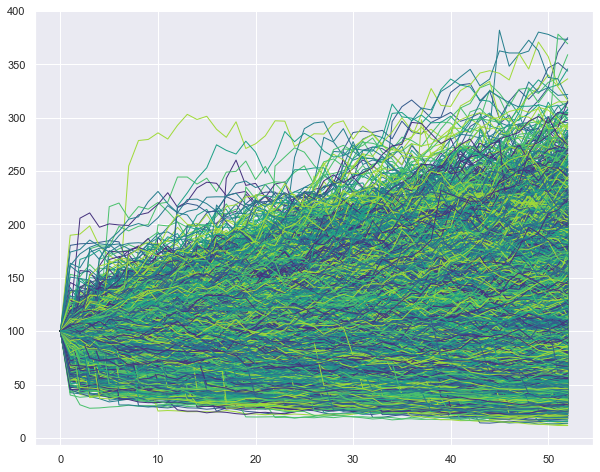

In [34]:
# gnerate random paths
stock_price = jump_diffusion(S0, K, T, r, sigma, Lambda, a, b, Nsteps, Nsim, alpha, seed)

In [35]:
LS_JD_52 = LS(stock_price, K, r, T, Nsteps, Nsim)
print(LS_JD_52)

Estimated conditional expectation function:            2
0.0004093 x - 1.053 x + 106.6
Estimated conditional expectation function:           2
-0.02085 x + 2.287 x - 26.46
Estimated conditional expectation function:           2
-0.01156 x + 0.8499 x + 30.54
Estimated conditional expectation function:            2
-0.009533 x + 0.5462 x + 42.16
Estimated conditional expectation function:            2
-0.008091 x + 0.3227 x + 50.86
Estimated conditional expectation function:           2
-0.00737 x + 0.2126 x + 55.12
Estimated conditional expectation function:            2
-0.006695 x + 0.1088 x + 59.11
Estimated conditional expectation function:          2
-0.0031 x - 0.4483 x + 78.62
Estimated conditional expectation function:            2
-0.004315 x - 0.261 x + 72.49
Estimated conditional expectation function:            2
-0.004506 x - 0.2318 x + 71.66
Estimated conditional expectation function:            2
-0.004397 x - 0.2468 x + 72.26
Estimated conditional expectation function:  

So after 100000 times of simulation, the option price, with 52 times of exercise dates, using LS algorithm with JD model is `8.0879`.

### 10. Summary

So far, we have applied 5 approaches:
- IFD
- MC
- CMC
- LS
- LS with JD model

to estimate two kinds of option price (with the same parameters):
- The American put option with 2 times exercise dates (including the maturity date), and 
- The American put option with 52 times (once a week) exercise dates.

For the good of comparison, the estimates of the option price are summarized as follows:

-| IFD | MC | CMC | LS | LS w/ JD
-|----|----|-----|----|---------
Option Price w/ 2 times exercise dates| 12.5271 | 12.4606 | 12.2080 | 12.1282 | ---
Option Price w/ 52 times exercise dates| 12.6087 | --- | --- | 7.4783 | 8.0879

## CONCLUSION